# This test compares a catenary composed of hinged bodies to the analytical solution


The analytical formula for a catenary is as follows:

Shape:
$$y = cosh(\frac{x}{a})$$

where

$$ a = \frac{T_0}{\lambda g} $$

Where ${T_0}$ is the horizontal force in a catenary which is constant.

The length of the catenary (s) equals:

$$ s = a \:sinh(\frac {x}{a}) $$

With the enpoints and length of the cable known, the unknown a can be solved numerically.

In these formulas s, x and y describe the catenary relative to its lowest point. 

Ref: https://en.wikipedia.org/wiki/Catenary


# Import the tools that we need

In [1]:
from DAVE import *
from DAVE.jupyter import *
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from numpy import sinh, cosh, sqrt


default resource folders:
C:\Users\beneden\Miniconda3\envs\DAVE2\lib\site-packages\DAVE\resources
C:\Users\beneden\DAVE_models
Blender found at: C:\Program Files\Blender Foundation\Blender 2.82\blender.exe
embedWindow(verbose=True): could not load k3d module, try:
> pip install k3d      # and if necessary:
> conda install nodejs


## Define catenary properties

In [2]:
mass_per_lengh = 100
length = 80
segments = 50
width = 60

## Solve the analytical formulas numerically

In [3]:
# We know the width and length of the catenary
# The standard formula for a catenary describe half of a symmetric catenary

s =  length / 2
x =  width / 2

# solve s = a sinh(x/a)

def should_be_zero(a):
    return a * sinh(x/a) - s

a_guess = 1
a = fsolve(should_be_zero, a_guess)

T0 = a * mass_per_lengh * 9.81

print(f'T0 (horizontal tension = {T0}')

T0 (horizontal tension = [21779.83993017]


## Solve using DAVE

In [4]:
s = Scene()

# construct the catenary


mass_per_body = mass_per_lengh * length / segments
segment_length = length / segments

endA = s.new_rigidbody('segment0', 
                       position = (-x, 0,0),
                       cog = (segment_length/2, 0,0), 
                       rotation = (-180,0,0),  # for better initial condition
                       mass = mass_per_body,
                       fixed = (True,True,True,True,False,True))  # rotation about y-axis allowed

previous = endA


for i in range(1,segments):
    
    current = s.new_rigidbody(f'segment{i}', 
                        position = (segment_length, 0,0),
                        cog = (segment_length/2, 0,0), 
                        mass = mass_per_body,
                        parent = previous,
                       fixed = (True,True,True,True,False,True))  # rotation about y-axis allowed
    
    previous = current


end_of_last_segment = s.new_axis('end_of_last_segment', position = (segment_length,0,0), parent=previous)
endB = s.new_axis('endB', position = (x,0,0))


s.new_connector2d('pull_to_endB', master = 'endB', slave=end_of_last_segment, k_linear=1e9)
    
    
s.solve_statics();

Solved to 0.0008404080721220453.


## Compare

### Horizontal tension at endpoints

In [5]:
# Check horizontal tension at the endpoints

T0_p1 = s['segment0'].connection_force[0]
T0_p2 = -s['endB'].connection_force[0]

print(f'End 1 = {T0_p1}')
print(f'End 2 = {T0_p2}')
print(f'Expected = {T0}')

End 1 = 21777.78277356879
End 2 = 21777.78277356879
Expected = [21779.83993017]


## Horizontal force in catenary

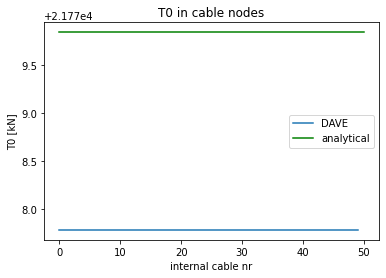

In [7]:
# Check the horizontal tension in the cable
# Two cables are connected to each of the internal points. Both cables should have the same horizontal
# tension and pull in opposite direction. Hence the total horizontal force on each of the internal pois
# should be zero

fx = []
for i in range(segments):
    node = s[f'segment{i}']
    fx.append(node.applied_force[0])

plt.plot(fx,label = 'DAVE')
plt.plot((0, segments),(T0,T0),'g-', label = "analytical")
plt.title('T0 in cable nodes')
plt.ylabel('T0 [kN]')
plt.xlabel('internal cable nr')
plt.legend();

## Catenary shape

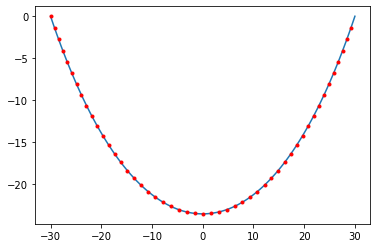

In [8]:
def y_analytical(x):
    return a * cosh(x/a)

xs = np.linspace(-x, x, num=100)
ys = y_analytical(xs)
y0 = y_analytical(x)

plt.plot(xs, ys-y0, label='analytical')

for b in s.nodes_of_type(RigidBody):
    plt.plot(b.gx, b.gz,'r.')

## Picture

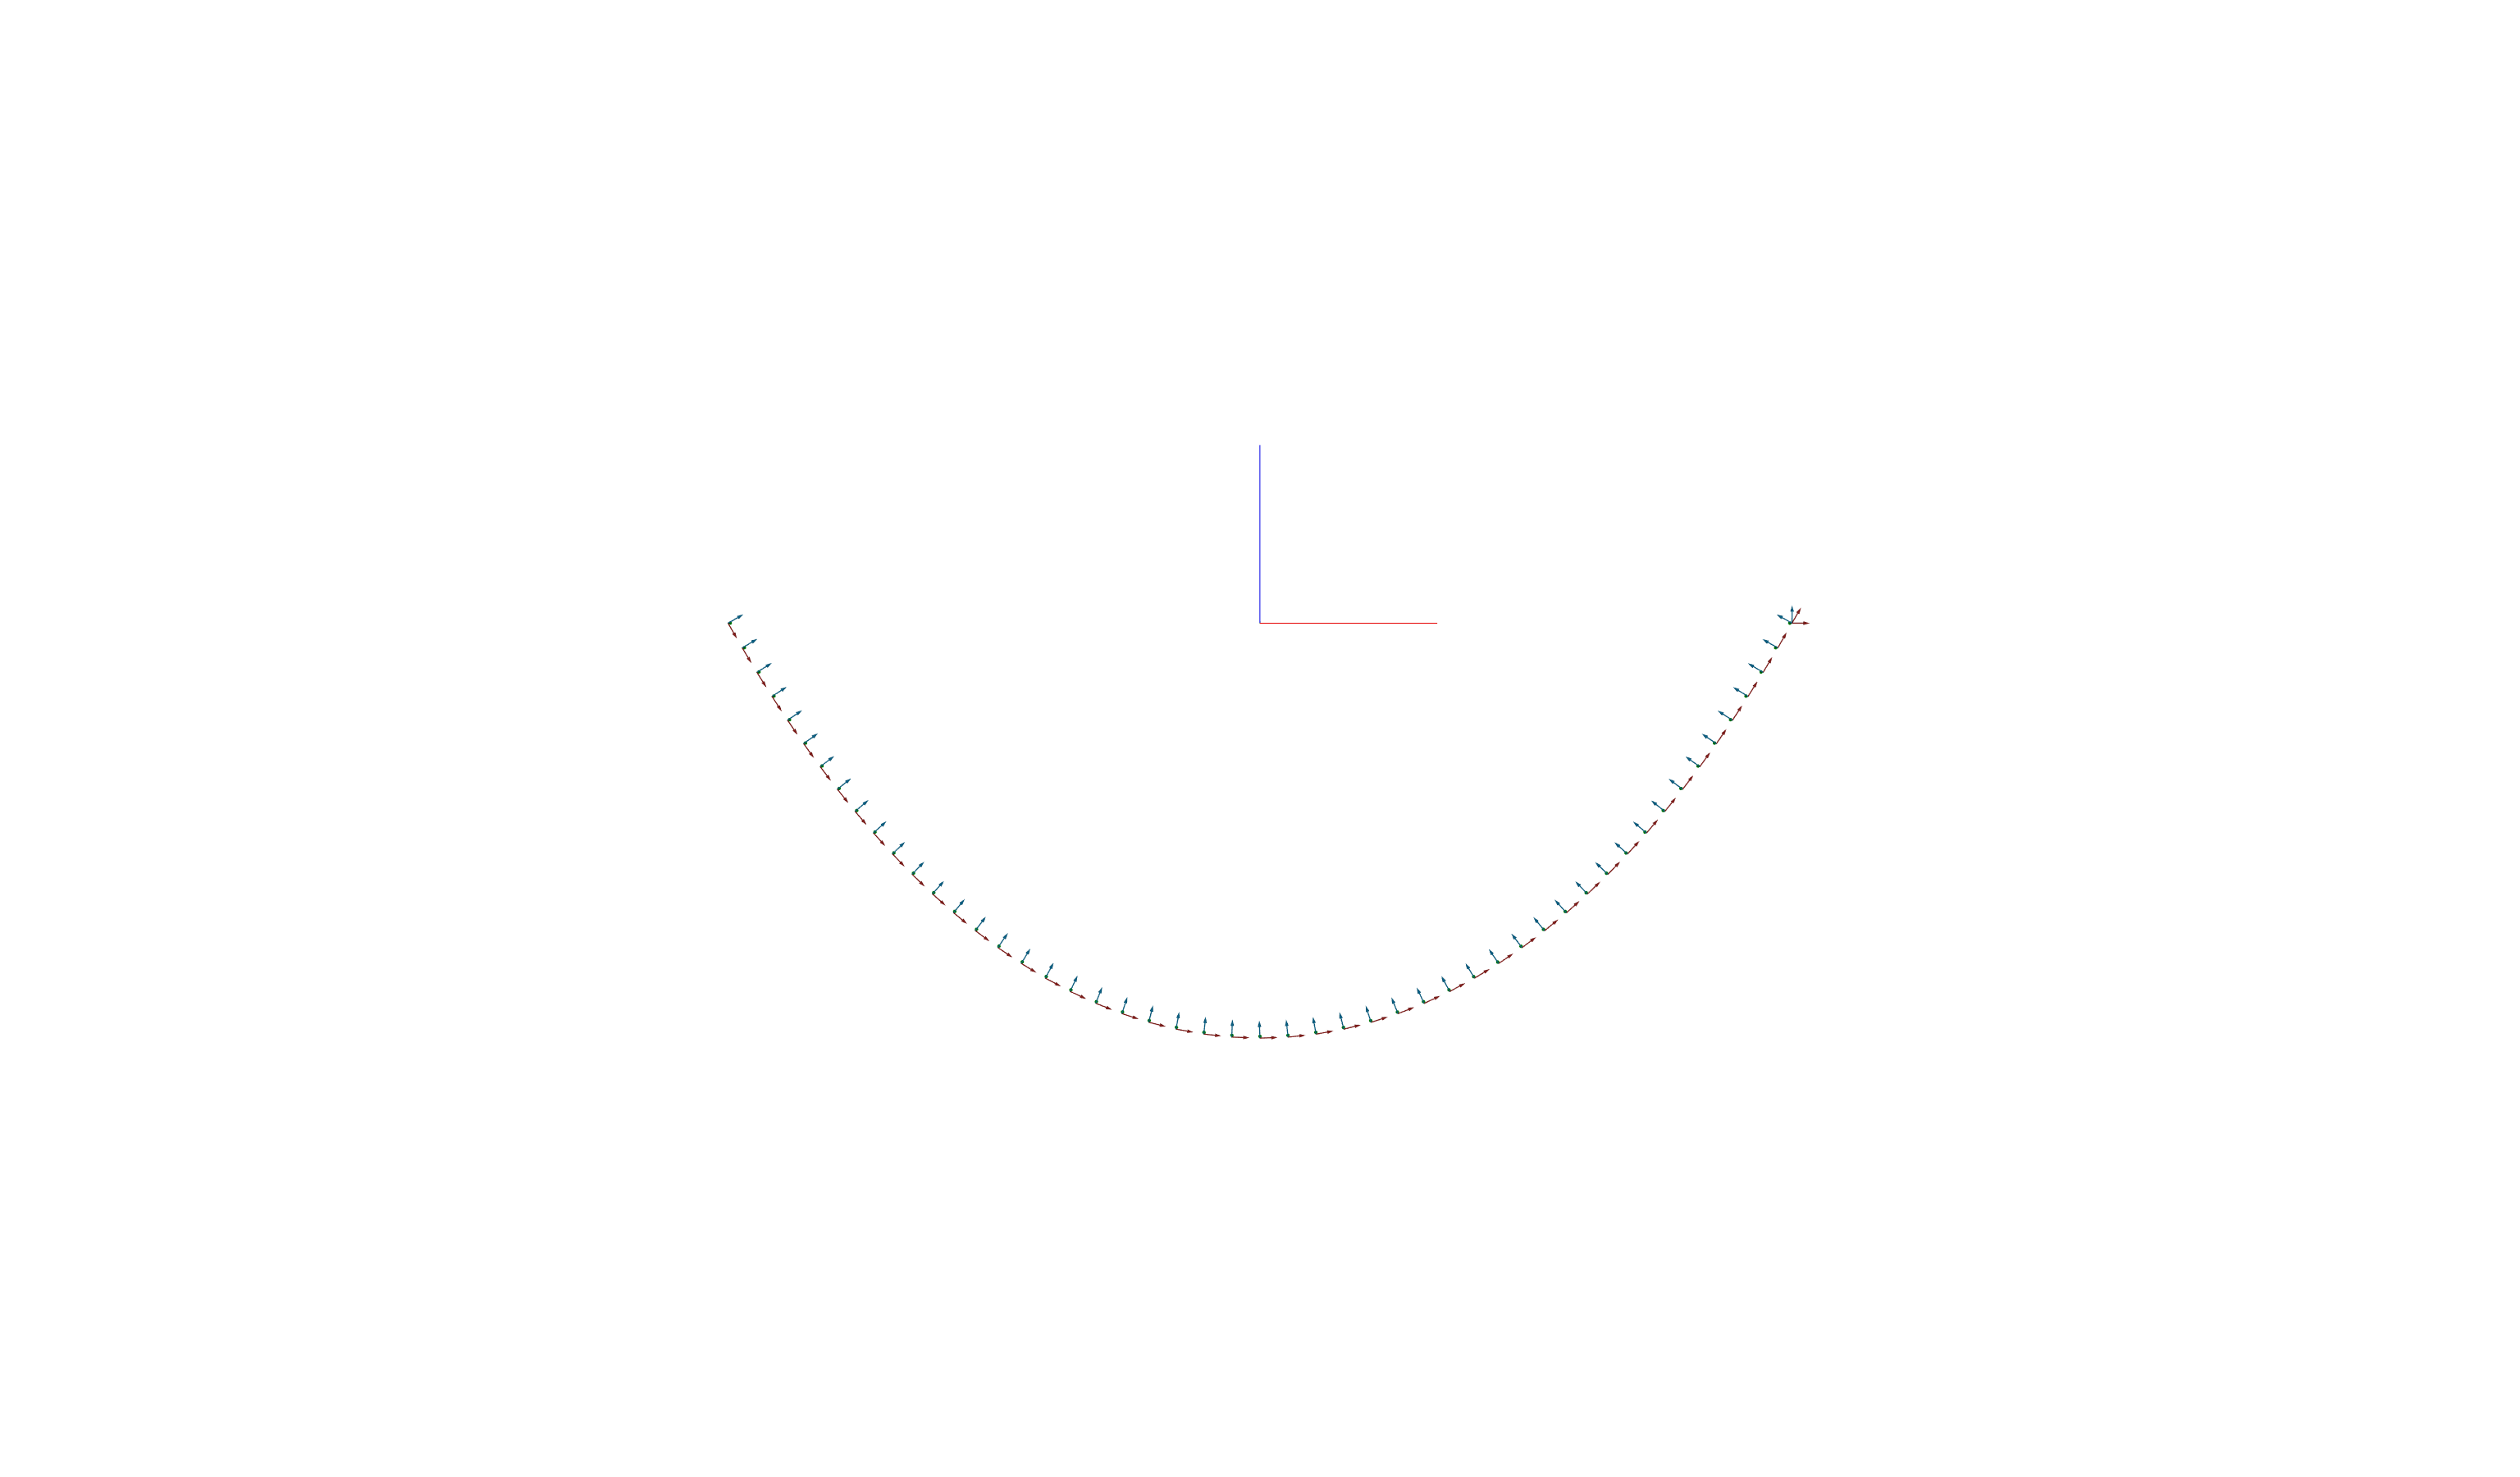

In [15]:
show(s, sea = False, camera_pos = (0.15395706315695745, -157.94371542848114, 1.5505097440465085), lookat = (0.0, 4.5, -6.740077863423391), cog_scale=0)